# 데이터 준비 과정

해당 부분은 코랩에서 실행하는 용도로, 다른 환경에서 실행하려면 Github에 올려놓은 데이터를 미리 다운받아 폴더에 압축해제하고, path의 경로를 해당 디렉토리로 변경해주시면 됩니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19338_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19339_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19339_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19340_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19340_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19341_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19341_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19342_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardio

In [2]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.0 MB/s eta 0:00:00


## 데이터 샘플링

In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
from sklearn.preprocessing import MultiLabelBinarizer

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df['filename_lr']]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df['filename_hr']]
    data = np.array([signal for signal, meta in data])
    return data


path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100

df = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))

agg_df = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


df['diagnostic_superclass'] = df.scp_codes.apply(aggregate_diagnostic)

df = df[df['diagnostic_superclass'].apply(lambda x: len(x) > 0)]

X = load_raw_data(df, sampling_rate, path)

assert len(X) == len(df), "X와 df의 크기가 일치하지 않습니다."
test_fold = 10
val_fold = 9

train_filter = (df.strat_fold != test_fold) & (df.strat_fold != val_fold)
val_filter = df.strat_fold == val_fold
test_filter = df.strat_fold == test_fold

X_train = X[train_filter]
y_train = list(df[train_filter]['diagnostic_superclass'])

X_val = X[val_filter]
y_val = list(df[val_filter]['diagnostic_superclass'])

X_test = X[test_filter]
y_test = list(df[test_filter]['diagnostic_superclass'])

mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)
y_val_bin = mlb.transform(y_val)
y_test_bin = mlb.transform(y_test)

print(f"Train Data Shape: {X_train.shape}, Labels: {y_train_bin.shape}")
print(f"Validation Data Shape: {X_val.shape}, Labels: {y_val_bin.shape}")
print(f"Test Data Shape: {X_test.shape}, Labels: {y_test_bin.shape}")


Train Data Shape: (17084, 1000, 12), Labels: (17084, 5)
Validation Data Shape: (2146, 1000, 12), Labels: (2146, 5)
Test Data Shape: (2158, 1000, 12), Labels: (2158, 5)


## 데이터 transform

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import os

class ECGDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ECGDataset(X_train, y_train_bin, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)



## pruned, 일반 모델용 EfficientNetV2S

In [11]:
#pruned, 일반 모델용
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

class Conv2dNormActivation(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation=nn.SiLU):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation(inplace=True)

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_channels):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Conv2d(in_channels, reduced_channels, kernel_size=1)
        self.fc2 = nn.Conv2d(reduced_channels, in_channels, kernel_size=1)
        self.activation = nn.SiLU(inplace=True)
        self.scale_activation = nn.Sigmoid()

    def forward(self, x):
        scale = self.avgpool(x)
        scale = self.fc2(self.activation(self.fc1(scale)))
        return x * self.scale_activation(scale)

class FusedMBConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        expanded_channels = int(in_channels * expand_ratio)

        if expand_ratio != 1:
            self.expand_conv = Conv2dNormActivation(in_channels, expanded_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.expand_conv = nn.Identity()

        self.depthwise_conv = Conv2dNormActivation(
            expanded_channels, expanded_channels, kernel_size, stride, kernel_size // 2
        )

        self.pointwise_conv = nn.Sequential(
            nn.Conv2d(expanded_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.se = SqueezeExcitation(
            expanded_channels, max(1, int(in_channels * se_ratio))
        ) if se_ratio > 0 else nn.Identity()

        self.stochastic_depth = StochasticDepth(stochastic_depth_prob)

    def forward(self, x):
        identity = x
        x = self.expand_conv(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        if self.use_residual:
            x = self.stochastic_depth(x) + identity
        return x

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        expanded_channels = int(in_channels * expand_ratio)

        self.expand_conv = nn.Conv2d(in_channels, expanded_channels, kernel_size=1, bias=False) if expand_ratio != 1 else nn.Identity()
        self.expand_bn = nn.BatchNorm2d(expanded_channels)
        self.expand_activation = nn.SiLU(inplace=True)

        self.depthwise_conv = nn.Conv2d(expanded_channels, expanded_channels, kernel_size=kernel_size, stride=stride,
                                        padding=kernel_size // 2, groups=expanded_channels, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(expanded_channels)
        self.depthwise_activation = nn.SiLU(inplace=True)

        reduced_channels = max(1, int(in_channels * se_ratio))
        self.se = SqueezeExcitation(expanded_channels, reduced_channels) if se_ratio > 0 else nn.Identity()

        self.pointwise_conv = nn.Conv2d(expanded_channels, out_channels, kernel_size=1, bias=False)
        self.pointwise_bn = nn.BatchNorm2d(out_channels)

        self.stochastic_depth = StochasticDepth(stochastic_depth_prob)

    def forward(self, x):
        identity = x
        x = self.expand_conv(x)
        if isinstance(self.expand_conv, nn.Conv2d):
            x = self.expand_bn(x)
            x = self.expand_activation(x)

        x = self.depthwise_conv(x)
        x = self.depthwise_bn(x)
        x = self.depthwise_activation(x)

        x = self.se(x)
        x = self.pointwise_conv(x)
        x = self.pointwise_bn(x)

        if self.use_residual:
            x = self.stochastic_depth(x) + identity
        return x

class StochasticDepth(nn.Module):
    def __init__(self, drop_prob):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1 - self.drop_prob
        batch_size = x.shape[0]
        random_tensor = torch.rand(batch_size, 1, 1, 1, device=x.device) < keep_prob
        return x * random_tensor / keep_prob

class EfficientNetV2S(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = self._build_features()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def _build_features(self):
        layers = [
            Conv2dNormActivation(3, 24, kernel_size=3, stride=2, padding=1),
            self._make_layer(24, 24, 3, 1, expand_ratio=1, se_ratio=0, stochastic_depth_prob=0.0, use_fused=True),
            self._make_layer(24, 48, 3, 2, expand_ratio=4, se_ratio=0, stochastic_depth_prob=0.01, use_fused=True),
            self._make_layer(48, 64, 3, 2, expand_ratio=4, se_ratio=0, stochastic_depth_prob=0.02, use_fused=True),
            self._make_layer(64, 128, 3, 2, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.03, use_fused=False),
            self._make_layer(128, 160, 3, 1, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.04, use_fused=False),
            self._make_layer(160, 256, 3, 2, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.05, use_fused=False),
            Conv2dNormActivation(256, 1280, kernel_size=1, stride=1, padding=0)
        ]
        return nn.Sequential(*layers)

    def _make_layer(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob, use_fused):
        if use_fused:
            return FusedMBConv(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob)
        else:
            return MBConvBlock(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## **QAT용 EfficientNetv2S 모델**

In [12]:
import torch
import torch.nn as nn


class Conv2dNormActivationQAT(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation=nn.ReLU):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation(inplace=True)

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))


class SqueezeExcitationQAT(nn.Module):
    def __init__(self, in_channels, reduced_channels):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Conv2d(in_channels, reduced_channels, kernel_size=1)
        self.fc2 = nn.Conv2d(reduced_channels, in_channels, kernel_size=1)
        self.activation = nn.ReLU(inplace=True)
        self.scale_activation = nn.Sigmoid()
        self.mul = torch.nn.quantized.FloatFunctional()


    def forward(self, x):
        scale = self.avgpool(x)
        scale = self.fc2(self.activation(self.fc1(scale)))
        return self.mul.mul(x, self.scale_activation(scale))


class StochasticDepthQAT(nn.Module):
    def __init__(self, drop_prob):
        super().__init__()
        self.drop_prob = drop_prob
        self.add = torch.nn.quantized.FloatFunctional()

    def forward(self, x, identity):
        if not self.training or self.drop_prob == 0.0:
            return self.add.add(x, identity)
        keep_prob = 1 - self.drop_prob
        batch_size = x.shape[0]
        random_tensor = torch.rand(batch_size, 1, 1, 1, device=x.device) < keep_prob
        return self.add.add(x * random_tensor / keep_prob, identity)


class FusedMBConvQAT(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        expanded_channels = int(in_channels * expand_ratio)

        if expand_ratio != 1:
            self.expand_conv = Conv2dNormActivationQAT(in_channels, expanded_channels, kernel_size=1, stride=1, padding=0, activation=nn.ReLU)
        else:
            self.expand_conv = nn.Identity()

        self.depthwise_conv = Conv2dNormActivationQAT(
            expanded_channels, expanded_channels, kernel_size, stride, kernel_size // 2, activation=nn.ReLU
        )

        self.pointwise_conv = nn.Sequential(
            nn.Conv2d(expanded_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.se = SqueezeExcitationQAT(
            expanded_channels, max(1, int(in_channels * se_ratio))
        ) if se_ratio > 0 else nn.Identity()

        self.stochastic_depth = StochasticDepthQAT(stochastic_depth_prob)

    def forward(self, x):
        identity = x
        x = self.expand_conv(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        if self.use_residual:
            x = self.stochastic_depth(x, identity)
        return x


class MBConvBlockQAT(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        expanded_channels = int(in_channels * expand_ratio)

        self.expand_conv = nn.Conv2d(in_channels, expanded_channels, kernel_size=1, bias=False) if expand_ratio != 1 else nn.Identity()
        self.expand_bn = nn.BatchNorm2d(expanded_channels)
        self.expand_activation = nn.ReLU(inplace=True)

        self.depthwise_conv = nn.Conv2d(expanded_channels, expanded_channels, kernel_size=kernel_size, stride=stride,
                                        padding=kernel_size // 2, groups=expanded_channels, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(expanded_channels)
        self.depthwise_activation = nn.ReLU(inplace=True)

        reduced_channels = max(1, int(in_channels * se_ratio))
        self.se = SqueezeExcitationQAT(expanded_channels, reduced_channels) if se_ratio > 0 else nn.Identity()

        self.pointwise_conv = nn.Conv2d(expanded_channels, out_channels, kernel_size=1, bias=False)
        self.pointwise_bn = nn.BatchNorm2d(out_channels)

        self.stochastic_depth = StochasticDepthQAT(stochastic_depth_prob)

    def forward(self, x):
        identity = x
        x = self.expand_conv(x)
        if isinstance(self.expand_conv, nn.Conv2d):
            x = self.expand_bn(x)
            x = self.expand_activation(x)

        x = self.depthwise_conv(x)
        x = self.depthwise_bn(x)
        x = self.depthwise_activation(x)

        x = self.se(x)
        x = self.pointwise_conv(x)
        x = self.pointwise_bn(x)

        if self.use_residual:
            x = self.stochastic_depth(x, identity)
        return x


class EfficientNetV2SQAT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = self._build_features()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def _build_features(self):
        layers = [
            Conv2dNormActivationQAT(3, 24, kernel_size=3, stride=2, padding=1, activation=nn.ReLU),
            self._make_layer(24, 24, 3, 1, expand_ratio=1, se_ratio=0, stochastic_depth_prob=0.0, use_fused=True),
            self._make_layer(24, 48, 3, 2, expand_ratio=4, se_ratio=0, stochastic_depth_prob=0.01, use_fused=True),
            self._make_layer(48, 64, 3, 2, expand_ratio=4, se_ratio=0, stochastic_depth_prob=0.02, use_fused=True),
            self._make_layer(64, 128, 3, 2, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.03, use_fused=False),
            self._make_layer(128, 160, 3, 1, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.04, use_fused=False),
            self._make_layer(160, 256, 3, 2, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.05, use_fused=False),
            Conv2dNormActivationQAT(256, 1280, kernel_size=1, stride=1, padding=0, activation=nn.ReLU)
        ]
        return nn.Sequential(*layers)

    def _make_layer(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob, use_fused):
        if use_fused:
            return FusedMBConvQAT(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob)
        else:
            return MBConvBlockQAT(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## EfficientNet2 훈련

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torchvision.models import efficientnet_v2_s
from torchvision import transforms
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = EfficientNetV2S(num_classes=y_train_bin.shape[1])

model.to(device)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def train_model(model, dataloader, num_epochs=60, patience=4, save_path='/content/drive/'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}...")
        running_loss = 0.0
        all_labels = []
        all_preds = []
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

        epoch_loss = running_loss / len(dataloader.dataset)
        accuracy = accuracy_score(np.vstack(all_labels), np.vstack(all_preds))
        f1 = f1_score(np.vstack(all_labels), np.vstack(all_preds), average='macro')
        precision = precision_score(np.vstack(all_labels), np.vstack(all_preds), average='macro')
        recall = recall_score(np.vstack(all_labels), np.vstack(all_preds), average='macro')

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1}.")

        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print('Training EfficientNetV2...')
train_model(model, dataloader, save_path='efficientnetv2_best.pth')
print('EfficientNetV2 training completed.')


Using device: cuda
Training EfficientNetV2...
Starting epoch 1/60...
Epoch [1/60], Loss: 0.3964, Accuracy: 0.4519, F1 Score: 0.5430, Precision: 0.6761, Recall: 0.4706
Model saved at epoch 1.
Starting epoch 2/60...
Epoch [2/60], Loss: 0.3490, Accuracy: 0.5188, F1 Score: 0.6274, Precision: 0.7286, Recall: 0.5627
Model saved at epoch 2.
Starting epoch 3/60...
Epoch [3/60], Loss: 0.3313, Accuracy: 0.5440, F1 Score: 0.6561, Precision: 0.7510, Recall: 0.5935
Model saved at epoch 3.
Starting epoch 4/60...
Epoch [4/60], Loss: 0.3194, Accuracy: 0.5601, F1 Score: 0.6725, Precision: 0.7637, Recall: 0.6114
Model saved at epoch 4.
Starting epoch 5/60...
Epoch [5/60], Loss: 0.3111, Accuracy: 0.5702, F1 Score: 0.6835, Precision: 0.7738, Recall: 0.6231
Model saved at epoch 5.
Starting epoch 6/60...
Epoch [6/60], Loss: 0.3008, Accuracy: 0.5863, F1 Score: 0.6972, Precision: 0.7798, Recall: 0.6396
Model saved at epoch 6.
Starting epoch 7/60...
Epoch [7/60], Loss: 0.2943, Accuracy: 0.5914, F1 Score: 0.705

## Pruning 훈련 모델

In [ ]:
def mask_gradient(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            param.grad[param.data == 0] = 0

def train_pruning_model(model, dataloader, num_epochs=60, patience=4, save_path='/content/drive/'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}...")
        running_loss = 0.0
        all_labels = []
        all_preds = []
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            mask_gradient(model)
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

        epoch_loss = running_loss / len(dataloader.dataset)
        accuracy = accuracy_score(np.vstack(all_labels), np.vstack(all_preds))
        f1 = f1_score(np.vstack(all_labels), np.vstack(all_preds), average='macro')
        precision = precision_score(np.vstack(all_labels), np.vstack(all_preds), average='macro')
        recall = recall_score(np.vstack(all_labels), np.vstack(all_preds), average='macro')

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1}.")
            for name, param in model.named_parameters():
                if "weight" in name:
                    print(f"{name}: {torch.sum(param == 0).item()} zeros out of {param.numel()}")

        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break









## Pruning 적용 훈련

pruning rate는 0.7로 하였고 prune.remove를 사용하여 masked 된 파라미터들을 모두 제거하였습니다.

In [ ]:
import torch.nn.utils.prune as prune
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torchvision import transforms
from torch.utils.data import DataLoader

def apply_pruning(model, amount=0.7):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")

model = EfficientNetV2S(num_classes=y_train_bin.shape[1])
model.load_state_dict(torch.load('efficientnetv2_self_best.pth'))
model.to(device)

apply_pruning(model, amount=0.7)

for name, param in model.named_parameters():
    if "weight" in name:
        print(f"{name}: {torch.sum(param == 0).item()} zeros out of {param.numel()}")




train_pruning_model(model, dataloader, save_path='efficientnetv2_pruned.pth')



<ipython-input-26-f8f13ce07f4a>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnetv2_self_best.pth'))


features.0.conv.weight: 454 zeros out of 648
features.0.bn.weight: 0 zeros out of 24
features.1.depthwise_conv.conv.weight: 3629 zeros out of 5184
features.1.depthwise_conv.bn.weight: 0 zeros out of 24
features.1.pointwise_conv.0.weight: 403 zeros out of 576
features.1.pointwise_conv.1.weight: 0 zeros out of 24
features.2.expand_conv.conv.weight: 1613 zeros out of 2304
features.2.expand_conv.bn.weight: 0 zeros out of 96
features.2.depthwise_conv.conv.weight: 58061 zeros out of 82944
features.2.depthwise_conv.bn.weight: 0 zeros out of 96
features.2.pointwise_conv.0.weight: 3226 zeros out of 4608
features.2.pointwise_conv.1.weight: 0 zeros out of 48
features.3.expand_conv.conv.weight: 6451 zeros out of 9216
features.3.expand_conv.bn.weight: 0 zeros out of 192
features.3.depthwise_conv.conv.weight: 232243 zeros out of 331776
features.3.depthwise_conv.bn.weight: 0 zeros out of 192
features.3.pointwise_conv.0.weight: 8602 zeros out of 12288
features.3.pointwise_conv.1.weight: 0 zeros out of

## QAT 함수 정의

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.quantization import QuantStub, DeQuantStub, fuse_modules, prepare_qat, convert

class QuantizableEfficientNetV2S(EfficientNetV2SQAT):
    def __init__(self, num_classes):
        super(QuantizableEfficientNetV2S, self).__init__(num_classes)
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)
        x = self.dequant(x)
        return x

    @staticmethod
    def fuse_model(model):
        for name, module in model.features.named_children():
            if isinstance(module, Conv2dNormActivationQAT):
                fuse_modules(module, ["conv", "bn", "activation"], inplace=True)
            elif isinstance(module, (FusedMBConvQAT, MBConvBlockQAT)):
                if hasattr(module, 'expand_conv') and isinstance(module.expand_conv, Conv2dNormActivationQAT):
                    fuse_modules(module.expand_conv, ["conv", "bn", "activation"], inplace=True)
                if hasattr(module, 'depthwise_conv') and isinstance(module.depthwise_conv, Conv2dNormActivationQAT):
                    fuse_modules(module.depthwise_conv, ["conv", "bn", "activation"], inplace=True)
                if hasattr(module, 'pointwise_conv') and isinstance(module.pointwise_conv, nn.Sequential):
                    fuse_modules(module.pointwise_conv, ["0", "1"], inplace=True)

class EfficientNetV2QAT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.quant = QuantStub()
        self.features = self._build_features()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )
        self.dequant = DeQuantStub()

    def _build_features(self):
        layers = [
            Conv2dNormActivationQAT(3, 24, kernel_size=3, stride=2, padding=1),
            self._make_layer(24, 24, 3, 1, expand_ratio=1, se_ratio=0, stochastic_depth_prob=0.0, use_fused=True),
            self._make_layer(24, 48, 3, 2, expand_ratio=4, se_ratio=0, stochastic_depth_prob=0.01, use_fused=True),
            self._make_layer(48, 64, 3, 2, expand_ratio=4, se_ratio=0, stochastic_depth_prob=0.02, use_fused=True),
            self._make_layer(64, 128, 3, 2, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.03, use_fused=False),
            self._make_layer(128, 160, 3, 1, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.04, use_fused=False),
            self._make_layer(160, 256, 3, 2, expand_ratio=6, se_ratio=0.25, stochastic_depth_prob=0.05, use_fused=False),
            Conv2dNormActivationQAT(256, 1280, kernel_size=1, stride=1, padding=0)
        ]
        return nn.Sequential(*layers)

    def _make_layer(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob, use_fused):
        if use_fused:
            return FusedMBConvQAT(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob)
        else:
            return MBConvBlockQAT(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, stochastic_depth_prob)

    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.dequant(x)
        return x

def fuse_efficientnet_layers(model):
    for module_name, module in model.named_children():
        if isinstance(module, Conv2dNormActivationQAT):
            fuse_modules(module, ['conv', 'bn', 'activation'], inplace=True)
        elif isinstance(module, nn.Sequential):
            fuse_efficientnet_layers(module)


## QAT 적용 훈련

해당 모델은 다른 환경에서 epoch=50으로 미리 훈련시킨 후, load_state_dict로 훈련시킨 모델을 다시 가져와서 훈련하였습니다. 해당 셀에서 10회 추가로 학습 시켰습니다

In [ ]:
model = QuantizableEfficientNetV2S(num_classes=y_train_bin.shape[1]).to("cpu")


model.eval()

fuse_efficientnet_layers(model)


model.train()
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
prepare_qat(model, inplace=True)
model.load_state_dict(torch.load("efficientnet_qat_trained.pth"))

def train_model_qat(model, dataloader, num_epochs=10, patience=3, save_path='qat_model.pth'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}...")
        running_loss = 0.0
        all_labels = []
        all_preds = []

        model.train()
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to("cpu").float(), labels.to("cpu").float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

        epoch_loss = running_loss / len(dataloader.dataset)
        accuracy = accuracy_score(np.vstack(all_labels), np.vstack(all_preds))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1}.")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
    convert(model, inplace=True)
    print("QAT complete. Model converted to quantized version.")
    torch.save(model.state_dict(), "efficientnet_qat_converted_final.pth")
    print("Quantized model saved.")

train_model_qat(model, dataloader, save_path='efficientnet_qat_final.pth')


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
<ipython-input-8-bd8e1e6cec4f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

Starting epoch 1/10...
Epoch [1/10], Loss: 0.0719, Accuracy: 0.8781
Model saved at epoch 1.
Starting epoch 2/10...
Epoch [2/10], Loss: 0.0664, Accuracy: 0.8898
Model saved at epoch 2.
Starting epoch 3/10...
Epoch [3/10], Loss: 0.0698, Accuracy: 0.8856
Starting epoch 4/10...
Epoch [4/10], Loss: 0.0651, Accuracy: 0.8897
Model saved at epoch 4.
Starting epoch 5/10...
Epoch [5/10], Loss: 0.0644, Accuracy: 0.8948
Model saved at epoch 5.
Starting epoch 6/10...
Epoch [6/10], Loss: 0.0636, Accuracy: 0.8941
Model saved at epoch 6.
Starting epoch 7/10...
Epoch [7/10], Loss: 0.0633, Accuracy: 0.8935
Model saved at epoch 7.
Starting epoch 8/10...
Epoch [8/10], Loss: 0.0600, Accuracy: 0.8975
Model saved at epoch 8.
Starting epoch 9/10...
Epoch [9/10], Loss: 0.0611, Accuracy: 0.8957
Starting epoch 10/10...
Epoch [10/10], Loss: 0.0590, Accuracy: 0.9020
Model saved at epoch 10.
QAT complete. Model converted to quantized version.
Quantized model saved.


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:407: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


## 평가지표

In [35]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2S(num_classes=y_train_bin.shape[1])


efficient_model = efficientnet_v2_s(weights=None)
num_classes = 5
efficient_model.classifier[1] = nn.Linear(efficient_model.classifier[1].in_features, num_classes)
efficient_model.load_state_dict(torch.load('efficientnetv2_best.pth'))


pruned_model = model
pruned_model.load_state_dict(torch.load('efficientnetv2_self_pruned.pth'))

quantized_model = QuantizableEfficientNetV2S(num_classes=y_train_bin.shape[1])
quantized_model.eval()
fuse_efficientnet_layers(quantized_model)
quantized_model.train()
quantized_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
prepare_qat(quantized_model, inplace=True)
quantized_model.load_state_dict(torch.load('efficientnet_qat_final.pth'))
torch.quantization.convert(quantized_model, inplace=True)
quantized_model.load_state_dict(torch.load("efficientnet_qat_converted_final.pth"))
quantized_model.eval()




def evaluate_model(model, dataloader, is_quantized=False):
    model.eval()
    all_labels = []
    all_probs = []

    device = next(model.parameters()).device

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)


            if is_quantized:
                inputs = torch.quantization.QuantStub()(inputs)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    fpr, tpr, _ = roc_curve(all_labels.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    preds = (all_probs > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, preds)
    f1 = f1_score(all_labels, preds, average="macro")
    precision = precision_score(all_labels, preds, average="macro")
    recall = recall_score(all_labels, preds, average="macro")

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
    }




test_dataset = ECGDataset(X_test, y_test_bin, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

efficient_model = efficient_model.to(device)
pruned_model = pruned_model.to(device)
quantized_model = quantized_model.to("cpu")

results = {}
for idx, model in enumerate([efficient_model, pruned_model], start=1):
    print(f"Evaluating Model {idx}...")
    results[f"model{idx}"] = evaluate_model(model, test_dataloader, is_quantized=False)

print("Evaluating quantized model")
results["quantized_model"] = evaluate_model(quantized_model, test_dataloader, is_quantized=True)

for model_name, metrics in results.items():
        print(f"{model_name}:")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  F1 Score: {metrics['f1']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")






<ipython-input-35-f31229c17ad6>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficient_model.load_state_dict(torch.load('efficientnetv2_best.pth'))
<ipython-input-35-f3

Evaluating Model 1...
Evaluating Model 2...
Evaluating quantized model
model1:
  Accuracy: 0.9742
  F1 Score: 0.9876
  Precision: 0.9913
model2:
  Accuracy: 0.9695
  F1 Score: 0.9860
  Precision: 0.9862
quantized_model:
  Accuracy: 0.9328
  F1 Score: 0.9411
  Precision: 0.9423


## Metrics 시각화

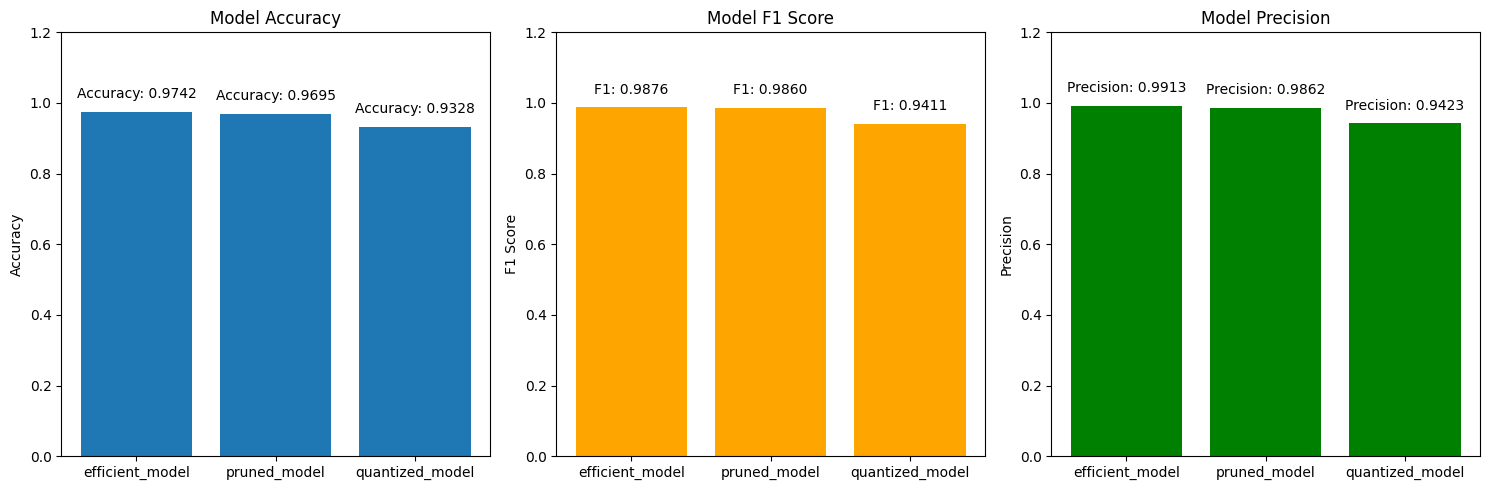

In [43]:
import matplotlib.pyplot as plt

# 시각화에 필요한 데이터 준비
model_names = list(results.keys())
accuracies = [results[model]["accuracy"] for model in model_names]
f1_scores = [results[model]["f1"] for model in model_names]
precisions = [results[model]["precision"] for model in model_names]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(model_names, accuracies)
ax[0].set_title("Model Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0, 2)
ax[0].set_xticks(range(len(model_names)))
ax[0].set_xticklabels(model_names)

ax[1].bar(model_names, f1_scores, color="orange")
ax[1].set_title("Model F1 Score")
ax[1].set_ylabel("F1 Score")
ax[1].set_ylim(0, 2)
ax[1].set_xticks(range(len(model_names)))
ax[1].set_xticklabels(model_names)

ax[2].bar(model_names, precisions, color="green")
ax[2].set_title("Model Precision")
ax[2].set_ylabel("Precision")
ax[2].set_ylim(0, 2)
ax[2].set_xticks(range(len(model_names)))
ax[2].set_xticklabels(model_names)

plt.tight_layout()
plt.show()


## 파일 크기

In [44]:
import os

model_files = {
    "efficient_model": "efficientnetv2_best.pth",
    "pruned_model": "efficientnetv2_self_pruned.pth",
    "quantized_model": "efficientnet_qat_converted_final.pth",
}

for model_name, file_path in model_files.items():
    file_size = os.path.getsize(file_path) / (1024 * 1024)
    print(f"{model_name} file size: {file_size:.2f} MB")


efficient_model file size: 77.86 MB
pruned_model file size: 6.40 MB
quantized_model file size: 1.89 MB


## 파일 크기 시각화

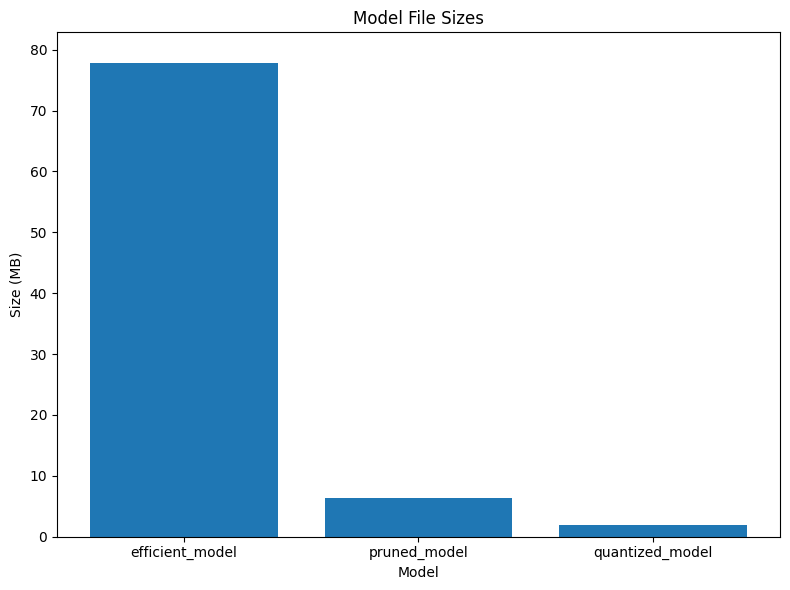

In [45]:
import os
import matplotlib.pyplot as plt

model_files = {
    "efficient_model": "efficientnetv2_best.pth",
    "pruned_model": "efficientnetv2_self_pruned.pth",
    "quantized_model": "efficientnet_qat_converted_final.pth",
}

model_sizes = {}
for model_name, file_path in model_files.items():
    file_size = os.path.getsize(file_path) / (1024 * 1024)
    model_sizes[model_name] = file_size

plt.figure(figsize=(8, 6))
plt.bar(model_sizes.keys(), model_sizes.values())
plt.title("Model File Sizes")
plt.ylabel("Size (MB)")
plt.xlabel("Model")
plt.ylim(0, max(model_sizes.values()) + 5)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()


## 추론 시간

In [46]:
import time

test_dataset = ECGDataset(X_test, y_test_bin, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def measure_inference_time_per_sample(model, dataloader, num_samples=10, device="cpu"):
    model.eval()
    model.to(device)

    total_time = 0.0
    with torch.no_grad():
        for idx, (inputs, _) in enumerate(dataloader):
            if idx >= num_samples:
                break

            inputs = inputs.to(device).float()
            start_time = time.time()
            _ = model(inputs)
            total_time += time.time() - start_time

    avg_time_per_sample = total_time / num_samples
    return avg_time_per_sample

device = "cpu"
models = [efficient_model, pruned_model, quantized_model]
dataloader = test_dataloader

for idx, model in enumerate(models, start=1):
    device_type = "cpu" if idx == 3 else device
    avg_time = measure_inference_time_per_sample(model, dataloader, num_samples=20, device=device_type)
    print(f"Model {idx} average inference time per sample: {avg_time:.6f} seconds")


Model 1 average inference time per sample: 0.060556 seconds
Model 2 average inference time per sample: 0.013355 seconds
Model 3 average inference time per sample: 0.010584 seconds


## 추론 시간 시각화

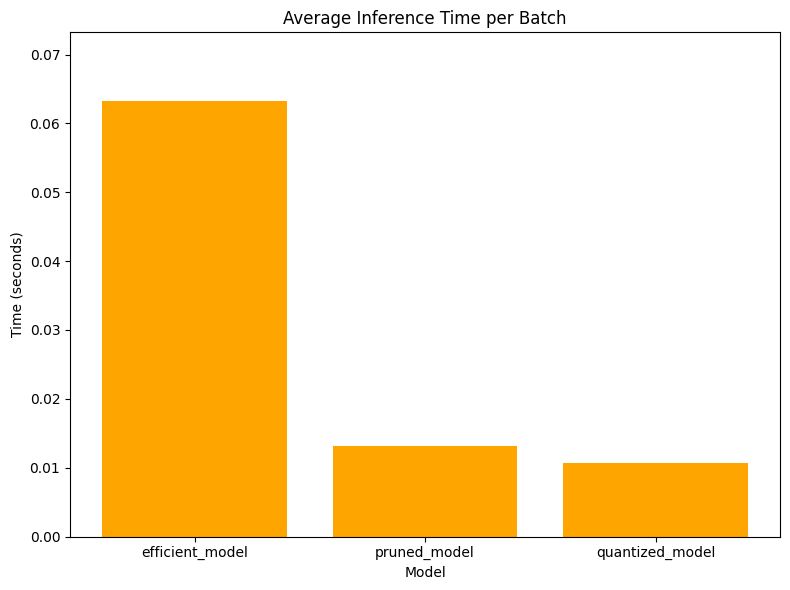

In [52]:
import matplotlib.pyplot as plt
import time
import torch

def measure_inference_time(model, dataloader, num_batches=5, device="cpu"):
    model.eval()
    model.to(device)
    total_time = 0.0
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            inputs = inputs.to(device).float()
            start_time = time.time()
            _ = model(inputs)
            total_time += time.time() - start_time
    return total_time / num_batches

device = "cpu"
models = [efficient_model, pruned_model, quantized_model]
model_names = ["efficient_model", "pruned_model", "quantized_model"]
dataloader = test_dataloader

inference_times = []
for idx, model in enumerate(models, start=1):
    device_type = "cpu" if idx == 3 else device
    avg_time = measure_inference_time(model, dataloader, num_batches=5, device=device_type)
    inference_times.append(avg_time)

plt.figure(figsize=(8, 6))
plt.bar(model_names, inference_times, color="orange")
plt.title("Average Inference Time per Batch")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.ylim(0, max(inference_times) + 0.01)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()
